###  Climate Analysis and Exploration using SQLAlchemy ORM queries, Pandas, and Matplotlib

In [1]:
# importing dependencies here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%load_ext nb_black
degree_sign = u"\N{DEGREE SIGN}"

<IPython.core.display.Javascript object>

### Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

<IPython.core.display.Javascript object>

In [3]:
db_path = os.path.join("..", "Resources", "hawaii.sqlite")
engine = create_engine(f"sqlite:///{db_path}")

<IPython.core.display.Javascript object>

In [4]:
inspector = inspect(engine)

<IPython.core.display.Javascript object>

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

<IPython.core.display.Javascript object>

In [6]:
# to view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

<IPython.core.display.Javascript object>

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

<IPython.core.display.Javascript object>

In [8]:
# creating session (link) from Python to the DB
session = Session(engine)

<IPython.core.display.Javascript object>

In [9]:
columns = inspector.get_columns("Measurement")

print("Columns and their types in Measurement Table")
print("--------------------------------------------")
for col in columns:
    print(col["name"], col["type"])

Columns and their types in Measurement Table
--------------------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


<IPython.core.display.Javascript object>

In [10]:
inspector.get_columns("Station")

columns = inspector.get_columns("Station")
print("Columns and their types in Station Table")
print("--------------------------------------------")
for col in columns:
    print(col["name"], col["type"])

Columns and their types in Station Table
--------------------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


<IPython.core.display.Javascript object>

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Sort the DataFrame values by `date`.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.

In [11]:
# checking the last date for precipitation data in the measurement table to extract last 12 months of data from the "last date"
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

<IPython.core.display.Javascript object>

In [12]:
date_twelve_months_ago = datetime.date(2017, 8, 23) - datetime.timedelta(days=365)
date_twelve_months_ago

datetime.date(2016, 8, 23)

<IPython.core.display.Javascript object>

In [13]:
# query to retrieve the last 12 months of precipitation data
prcp_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(
        Measurement.date
        > date_twelve_months_ago
    )
    .group_by(Measurement.date)
    .all()
)

<IPython.core.display.Javascript object>

In [14]:
len(prcp_data)

365

<IPython.core.display.Javascript object>

In [15]:
# storing the last 12 months of precipitation data in a dataframe
prcp_df = (
    pd.DataFrame(prcp_data, columns=["date", "prcp"])
    .sort_values("date")
    .set_index("date")
)

<IPython.core.display.Javascript object>

In [16]:
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


<IPython.core.display.Javascript object>

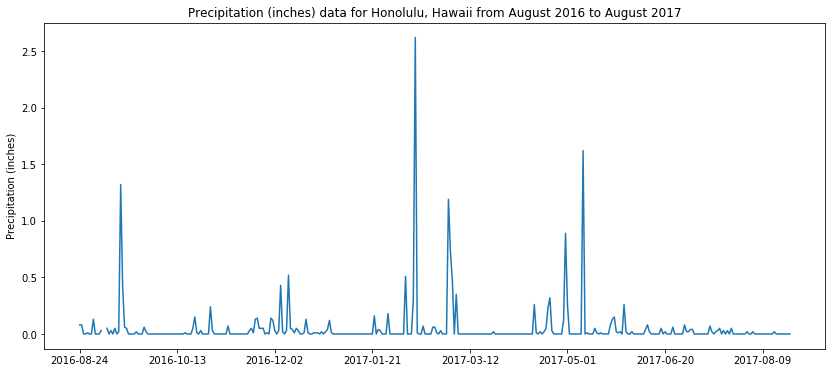

<IPython.core.display.Javascript object>

In [17]:
# plotting last 12 months of precipitation data
prcp_df.plot(figsize=(14, 6), legend=None)
plt.xlabel(None)
plt.ylabel("Precipitation (inches)")
plt.title(
    "Precipitation (inches) data for Honolulu, Hawaii from August 2016 to August 2017"
)
plt.show()

In [18]:
# summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


<IPython.core.display.Javascript object>

### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order.

  * Which station has the highest number of observations?

  * Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [19]:
# query to calculate the total number of unique stations available in the Station dataset
total_station = session.query(Station.station).distinct().count()
print(
    "Total Number of Unique Stations present in the Station dataset is: ", total_station
)

Total Number of Unique Stations present in the Station dataset is:  9


<IPython.core.display.Javascript object>

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (
    session.query(Station.station, func.count(Measurement.station))
    .filter(Station.station == Measurement.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

<IPython.core.display.Javascript object>

In [21]:
# station with highest number of observations
print("Most Active Station is: ", active_stations[0][0])
print(
    "Total Number of observations for the most active station is: ",
    active_stations[0][1],
)

Most Active Station is:  USC00519281
Total Number of observations for the most active station is:  2772


<IPython.core.display.Javascript object>

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature for most active station
temps = (
    session.query(
        Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == active_stations[0][0])
    .all()
)

print("Most Active Station is:", temps[0][0])
print("----------------------------------------------------")
print(f"Lowest Temp Recorded for this station is: {temps[0][1]}{degree_sign}F")
print(f"Highest Temp Recorded for this station is: {temps[0][2]}{degree_sign}F")
print(
    f"Average Temp Recorded for this station is: {round(temps[0][3], 2)}{degree_sign}F"
)

Most Active Station is: USC00519281
----------------------------------------------------
Lowest Temp Recorded for this station is: 54.0°F
Highest Temp Recorded for this station is: 85.0°F
Average Temp Recorded for this station is: 71.66°F


<IPython.core.display.Javascript object>

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
a_year_of_temps = (
    session.query(Measurement.station, Measurement.tobs)
    .filter(Measurement.date >= date_twelve_months_ago)
    .filter(Measurement.station == active_stations[0][0])
    .all()
)

most_active_station_tob_df = pd.DataFrame(a_year_of_temps).rename(
    columns={"tobs": f"Temperature Observations {degree_sign}F"}
)
most_active_station_tob_df.head()

,station,Temperature Observations °F
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


<IPython.core.display.Javascript object>

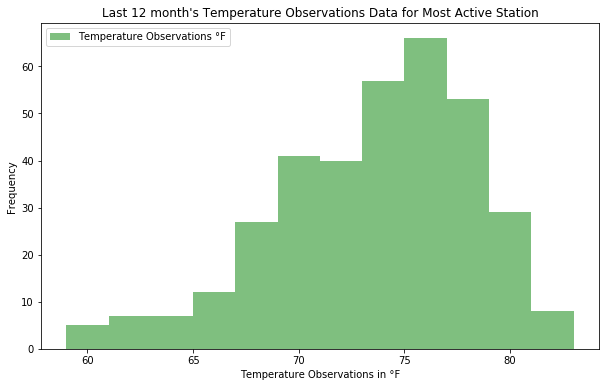

<IPython.core.display.Javascript object>

In [24]:
# plot the last 12 months temperature observations data for the most active station using a histogram with bins=12
most_active_station_tob_df.plot(
    kind="hist", bins=12, figsize=(10, 6), color="green", alpha=0.5
)
plt.xlabel(f"Temperature Observations in {degree_sign}F")
plt.ylabel("Frequency")
plt.title("Last 12 month's Temperature Observations Data for Most Active Station")
plt.show()

### Temperature Analysis

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates


def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


<IPython.core.display.Javascript object>

In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

trip_start_date = "2018-08-01"
trip_end_date = "2018-08-10"

print("Trip Start Date is: ", trip_start_date)
print("Trip End Date is: ", trip_end_date)
print("-------------------------------------------------------------------")

t1 = datetime.date(2018, 8, 1) - datetime.timedelta(days=365)
print("Start Date from previous year based on 'trip start date' is: ", t1)

t2 = datetime.date(2018, 8, 10) - datetime.timedelta(days=365)
print("End Date from previous year based on 'trip end date' is: ", t2)
print("--------------------------------------------------------------------")

trip_temperature_df = pd.DataFrame(calc_temps(t1, t2), columns=["Min", "Avg", "Max"])
trip_temperature_df

Trip Start Date is:  2018-08-01
Trip End Date is:  2018-08-10
-------------------------------------------------------------------
Start Date from previous year based on 'trip start date' is:  2017-08-01
End Date from previous year based on 'trip end date' is:  2017-08-10
--------------------------------------------------------------------


,Min,Avg,Max
0,71.0,79.025641,83.0


<IPython.core.display.Javascript object>

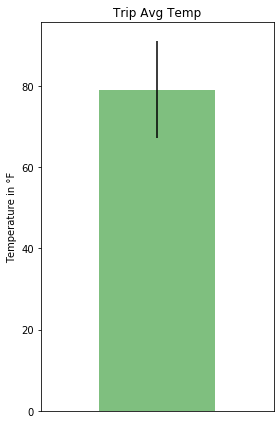

<IPython.core.display.Javascript object>

In [27]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title. Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temperature_df.plot.bar(
    y="Avg",
    yerr=(trip_temperature_df["Max"] - trip_temperature_df["Min"]),
    title="Trip Avg Temp",
    color="green",
    alpha=0.5,
    figsize=(4, 6),
    legend=None,
)
plt.xticks([])
plt.ylabel(f"Temperature in {degree_sign}F")
plt.tight_layout()
plt.show()

### Daily Rainfall Average.

* Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_total_rainfall = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.round(func.sum(Measurement.prcp), 2),
    )
    .filter(Station.station == Measurement.station)
    .filter(Measurement.date >= t1)
    .filter(Measurement.date <= t2)
    .group_by(Station.station)
    .order_by(func.sum(Measurement.prcp).desc())
    .all()
)

for t in trip_total_rainfall:
    print(t)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.92)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.32)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)


<IPython.core.display.Javascript object>

In [29]:
# storing the trip_total_rainfall data in a dataframe
cols = ["station", "name", "latitude", "longitude", "elevation", "total prcp"]
trip_rainfall_df = pd.DataFrame(np.array(trip_total_rainfall), columns=cols)
trip_rainfall_df

,station,name,latitude,longitude,elevation,total prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.92
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.32
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.0


<IPython.core.display.Javascript object>

In [30]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):

    """Daily Normals.    
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

<IPython.core.display.Javascript object>

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print("Trip Start Date is: ", trip_start_date)
print("Trip End Date is: ", trip_end_date)
print("--------------------------------------------------------------------------")

t1 = datetime.date(2018, 8, 1) - datetime.timedelta(days=365)
print("Start Date from previous year based on 'trip start date' is: ", t1)

t2 = datetime.date(2018, 8, 10) - datetime.timedelta(days=365)
print("End Date from previous year based on 'trip end date' is: ", t2)
print("--------------------------------------------------------------------------")

num_of_trip_days = t2 - t1
print("Number of Trip Days is: ", num_of_trip_days)
print("--------------------------------------------------------------------------")

# ================================================================================================================

trip_date_range = []

while t1 < t2:
    trip_date_range.append(t1)
    t1 += datetime.timedelta(days=1)

print(
    "Date Range (including Year) from last year based on Trip Date: \n", trip_date_range
)
print(
    "-------------------------------------------------------------------------------------"
)

# Strip off the year and save a list of %m-%d strings
i = 0
while i < (len(trip_date_range)):
    trip_date_range[i] = trip_date_range[i].strftime("%m-%d")
    i += 1

print(
    "Trip Date Range (Month and Day) from last year based on Trip Date: \n",
    trip_date_range,
)
print(
    "-------------------------------------------------------------------------------------"
)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_date_range:
    normals.append(daily_normals(date)[0])

print("Daily Normals (Min, Avg, Max) based on Trip Date Range: \n", normals)

Trip Start Date is:  2018-08-01
Trip End Date is:  2018-08-10
--------------------------------------------------------------------------
Start Date from previous year based on 'trip start date' is:  2017-08-01
End Date from previous year based on 'trip end date' is:  2017-08-10
--------------------------------------------------------------------------
Number of Trip Days is:  9 days, 0:00:00
--------------------------------------------------------------------------
Date Range (including Year) from last year based on Trip Date: 
 [datetime.date(2017, 8, 1), datetime.date(2017, 8, 2), datetime.date(2017, 8, 3), datetime.date(2017, 8, 4), datetime.date(2017, 8, 5), datetime.date(2017, 8, 6), datetime.date(2017, 8, 7), datetime.date(2017, 8, 8), datetime.date(2017, 8, 9)]
-------------------------------------------------------------------------------------
Trip Date Range (Month and Day) from last year based on Trip Date: 
 ['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '0

<IPython.core.display.Javascript object>

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = (
    pd.DataFrame(np.array(normals), columns=["min", "avg", "max"])
    .assign(trip_dates=trip_date_range)
    .set_index("trip_dates")
)
trip_normals_df

,min,avg,max
trip_dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0


<IPython.core.display.Javascript object>

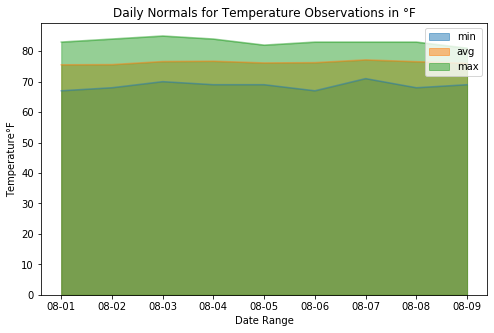

<IPython.core.display.Javascript object>

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot(kind="area", figsize=(8, 5), stacked=False, alpha=0.5)
plt.xlabel("Date Range")
plt.ylabel(f"Temperature{degree_sign}F")
plt.legend(loc="upper right")
plt.title(f"Daily Normals for Temperature Observations in {degree_sign}F")
plt.show()